### Classifier for Inside/Outside City

In [2]:
import pandas as pd
import numpy as np
import torch
import torchtext
import torchdata
import portalocker
from wordsegment import load, segment
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
from itertools import combinations
from torchtext.vocab import GloVe

torch.manual_seed(0)

In [3]:
#import dataset
tweets_analysis = pd.read_csv("final_tweets_set.csv")
final_tweets = tweets_analysis[["inside", "text_clean", "city"]]

In [4]:
#import twitter based glove embeddings
glove = GloVe(name='twitter.27B', dim = 200)

100%|████████████████████████████████████████████████████████████████████████████████████▉| 1193513/1193514 [00:53<00:00, 22239.13it/s]


In [5]:
#Create custom dataset
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, txt, labels, city):
        self.labels = labels
        self.text = txt
        self.city = city
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        city = self.city[idx]
        return (label, text, city)

In [6]:
final_tweets.rename(columns = {"inside": "Class", "text_clean": "Text"}, inplace = True)

/var/folders/8r/33488zyj26x492g8pxrnm_jh0000gn/T/ipykernel_2000/1862403789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_tweets.rename(columns = {"inside": "Class", "text_clean": "Text"}, inplace = True)


In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

#Collate Function

def collate_into_cbow(batch):
    """
    Processes batch of data
    Creates glove embeddings 
    """
    k = len(batch)
    label_list, original_text, text_list, cities = [], [], [], []
    
    max_words = 0
    for i, (label, text, city) in enumerate(batch): 
        label_list.append(label)
        original_text.append(text)
        cities.append(city)
        text = glove.get_vecs_by_tokens(tokenizer(text)).mean(dim =0)
        text_list.append(text)
    label_list = torch.tensor(label_list, dtype = torch.int64)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return label_list, text_list, original_text, cities

In [12]:
#Basic Logistic Regression Model

from torch import nn
import torch.nn.functional as F

class LogClassifier(nn.Module):
    """
    Basic Logistic Regression Model
    """
    
    def __init__(self, num_labels, vocab_size):
        
        super(LogClassifier, self).__init__()
        
        self.linear = nn.Linear(vocab_size, num_labels)
        
    def forward(self, bow_vec):
        
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [13]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    """
    Conducts a training step on dataloader
    
    Inputs:
        dataloader object
        specified optimzier
    
    """
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text, _, _ ) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [14]:
def get_accuracy(dataloader):
    """
    Calculates the accuracy of the model over batches
    of dataloader
    """
    
    model.eval()
    accuracy = []
    
    with torch.no_grad():
        count = 0 
        correct = 0
        for idx, (label, text, _, _) in enumerate(dataloader):
            log_probs = model(text)
            predicted_label = torch.argmax(log_probs, dim = 1)
            count = count + len(label)
            correct = correct + torch.where(label == predicted_label, 1, 0).sum()

    return correct/count

In [15]:
def get_accuracy_test(test_dataloader): 
    """
    computes accuracy and returns additional
    information for test data
    """
    model.eval()
    #accuracy = []
    original_text = []
    predictions = []
    correct_labels = []
    correct_pred = []
    cities = []
    
    with torch.no_grad():
        count = 0 
        correct = 0
        for idx, (label, text, original, city) in enumerate(test_dataloader):
            log_probs = model(text)
            predicted_label = torch.argmax(log_probs, dim = 1)
            predictions.extend(predicted_label)
            correct_labels.extend(label)
            original_text.extend(original)
            cities.extend(city)
            count = count + len(label)
            correct = correct + torch.where(label == predicted_label, 1, 0).sum()
            correct_pred.extend(torch.where(label == predicted_label, 1, 0))
    
    print("test accuracy:", correct/count)
    return original_text, correct_labels, cities, predictions, correct_pred
    

In [21]:
torch.manual_seed(0)
TD = CustomTextDataset(final_tweets['Text'], final_tweets['Class'], final_tweets['city'])
BATCH_SIZE = 64
train_size = int(0.8 * len(TD))
test_size = (len(TD) - train_size)//2
valid_size = len(TD) - train_size - test_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(TD, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_cbow)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_cbow)


## Run Basic Logistic Regression Model


After epoch 1 the validation accuracy is 0.640.


After epoch 2 the validation accuracy is 0.652.


After epoch 3 the validation accuracy is 0.663.


After epoch 4 the validation accuracy is 0.660.


After epoch 5 the validation accuracy is 0.663.


After epoch 6 the validation accuracy is 0.659.


After epoch 7 the validation accuracy is 0.663.


After epoch 8 the validation accuracy is 0.676.


After epoch 9 the validation accuracy is 0.663.


After epoch 10 the validation accuracy is 0.668.


After epoch 11 the validation accuracy is 0.669.


After epoch 12 the validation accuracy is 0.669.


After epoch 13 the validation accuracy is 0.675.


After epoch 14 the validation accuracy is 0.670.


After epoch 15 the validation accuracy is 0.673.


After epoch 16 the validation accuracy is 0.674.


After epoch 17 the validation accuracy is 0.674.


After epoch 18 the validation accuracy is 0.671.


After epoch 19 the validation accuracy is 0.678.


After epoch 20 the validation accuracy 

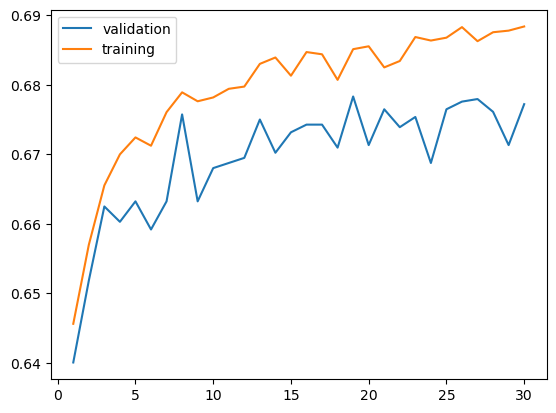

In [89]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

model = LogClassifier(2, 200)

EPOCHS = 30 # epoch

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

val_accuracies=[]
train_accuracies = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    val_accuracy = get_accuracy(valid_dataloader)
    val_accuracies.append(val_accuracy)
    train_accuracy = get_accuracy(train_dataloader)
    train_accuracies.append(train_accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {val_accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), val_accuracies, label = "validation")
plt.plot(range(1, EPOCHS+1), train_accuracies, label = "training")
plt.legend()

In [96]:
#get test accuracy
original_text, correct_labels, city, predictions, correct_pred = get_accuracy_test(test_dataloader)

test accuracy: tensor(0.6706)


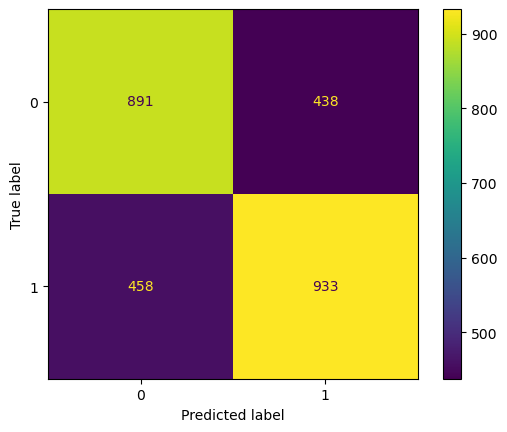

In [97]:
#create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(correct_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [98]:
from torchmetrics.classification import BinaryF1Score
metric = BinaryF1Score()
metric(torch.tensor(predictions), torch.tensor(correct_labels))

tensor(0.6756)

## Run Neural Net Classifier with 1 Hidden Layer

In [99]:
class ClassifierNN(nn.Module):
    """
    Classifier with 1 hidden layer
    """
    
    def __init__(self,
                 embedding_dim,
                hidden_dim,
                   output_dim,
                   nonlinearity):
        
        super(ClassifierNN, self).__init__()

        self.embed_hidden = nn.Linear(embedding_dim, hidden_dim)

        self.nonlinearity = nonlinearity
        
        self.hidden_to_label = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, bow_vec):
        
        h = self.nonlinearity(self.embed_hidden(bow_vec))
        y_tilda = self.hidden_to_label(h)
                                          
        return F.log_softmax(y_tilda, 1)



After epoch 1 the validation accuracy is 0.664.


After epoch 2 the validation accuracy is 0.683.


After epoch 3 the validation accuracy is 0.690.


After epoch 4 the validation accuracy is 0.699.


After epoch 5 the validation accuracy is 0.708.


After epoch 6 the validation accuracy is 0.712.


After epoch 7 the validation accuracy is 0.718.


After epoch 8 the validation accuracy is 0.724.


After epoch 9 the validation accuracy is 0.725.


After epoch 10 the validation accuracy is 0.721.


After epoch 11 the validation accuracy is 0.718.


After epoch 12 the validation accuracy is 0.730.


After epoch 13 the validation accuracy is 0.723.


After epoch 14 the validation accuracy is 0.719.


After epoch 15 the validation accuracy is 0.728.



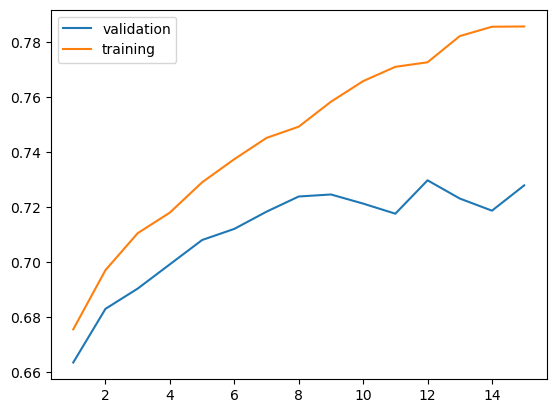

In [100]:
torch.manual_seed(0)
TD = CustomTextDataset(final_tweets['Text'], final_tweets['Class'], final_tweets['city'])
BATCH_SIZE = 64
train_size = int(0.8 * len(TD))
test_size = (len(TD) - train_size)//2
valid_size = len(TD) - train_size - test_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(TD, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_cbow)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_cbow)


import matplotlib.pyplot as plt
%matplotlib inline


model = ClassifierNN(embedding_dim = 200, 
                        hidden_dim = 50,
                        output_dim = 2, 
                        nonlinearity = nn.ReLU())


EPOCHS = 15 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


val_accuracies=[]
train_accuracies = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    val_accuracy = get_accuracy(valid_dataloader)
    val_accuracies.append(val_accuracy)
    train_accuracy = get_accuracy(train_dataloader)
    train_accuracies.append(train_accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {val_accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), val_accuracies, label = "validation")
plt.plot(range(1, EPOCHS+1), train_accuracies, label = "training")
plt.legend()

In [101]:
original_text, correct_labels, city, predictions, correct_preds = get_accuracy_test(test_dataloader)

test accuracy: tensor(0.7246)


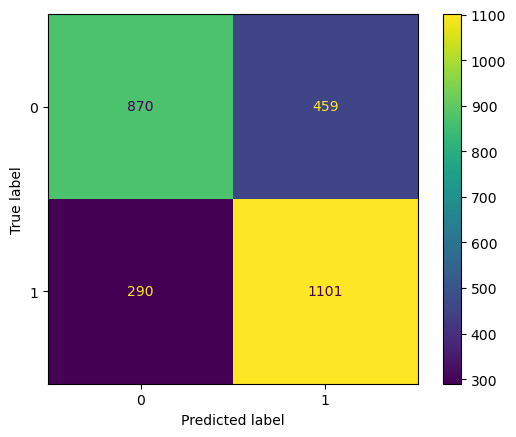

In [28]:
cm = confusion_matrix(correct_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [102]:
from torchmetrics.classification import BinaryF1Score
metric = BinaryF1Score()
metric(torch.tensor(predictions), torch.tensor(correct_labels))

tensor(0.7462)

### Analysis based on Neural Net Predictions

In [29]:
#original_text, correct_labels, city, predictions, correct_preds
correct_labels = [x.item() for x in correct_labels]
predictions = [x.item() for x in predictions]
correct_preds = [x.item() for x in correct_preds]

In [30]:
tweet_results = {"Text": original_text, "Labels": correct_labels,
                 "City": city, "Predictions": predictions, "Correct": correct_preds}

In [31]:
final_results_df = pd.DataFrame(tweet_results, columns = ["Text", "Labels", "City", "Predictions", "Correct"])

In [32]:
final_results_df_clean = final_results_df.copy()

In [33]:
growing = ["Tampa", "Kansas City", "Raleigh", "Fort Worth", "San Antonio", "Phoenix", "Las Vegas", "Jacksonville"]

In [34]:
import numpy as np

In [35]:
def f(row):
    growing = ["Tampa", "Kansas City", "Raleigh", "Fort Worth", "San Antonio", "Phoenix", "Las Vegas", "Jacksonville"]
    if row['City'] in growing:
        val = 1
    else:
        val = 0
    return val

In [36]:
final_results_df_clean['growing'] = final_results_df_clean.apply(f, axis=1)

In [37]:
final_results_df_clean

,Text,Labels,City,Predictions,Correct,growing
0,highest in the room new york new yorkcity manh...,1,New York,1,1,0
1,accident cleared in fort worth on w sb at gold...,1,Fort Worth,1,1,1
2,san antonio musician passed away in houston do...,1,San Antonio,0,0,1
3,there are still days for you to make a donatio...,1,Philadelphia,1,1,0
4,hunka hunka burning phoenix sunset arizona pho...,1,Phoenix,1,1,1
...,...,...,...,...,...,...
2715,doobie says im a good boy ruff ruff dog dogsof...,1,San Francisco,1,1,0
2716,crash only right lane gets by in fort worth on...,1,Fort Worth,1,1,1
2717,peaceful demonstration no filter south loop th...,1,Chicago,1,1,0
2718,someone take me back years ago new york new yo...,1,New York,1,1,0


In [38]:
growing_results = final_results_df_clean.loc[(final_results_df_clean.loc[:, "growing"] ==1), :]
shrinking_results = final_results_df_clean.loc[(final_results_df_clean.loc[:, "growing"] ==0), :]

In [39]:
out_growing = growing_results.groupby('City')['Correct'].value_counts(normalize=True)
out_shrinking = shrinking_results.groupby('City')['Correct'].value_counts(normalize=True)

In [40]:
pd.DataFrame(out_growing)

Correct
City         Correct          
Fort Worth   1        0.840000
             0        0.160000
Jacksonville 1        0.640000
             0        0.360000
Kansas City  1        0.620690
             0        0.379310
Las Vegas    1        0.718391
             0        0.281609
Phoenix      1        0.736842
             0        0.263158
Raleigh      1        0.725714
             0        0.274286
San Antonio  1        0.786164
             0        0.213836
Tampa        1        0.658537
             0        0.341463

In [41]:
pd.DataFrame(out_shrinking)

Correct
City          Correct          
Boston        1        0.688623
              0        0.311377
Chicago       1        0.695122
              0        0.304878
Los Angeles   1        0.726115
              0        0.273885
New Orleans   1        0.688742
              0        0.311258
New York      1        0.717391
              0        0.282609
Philadelphia  1        0.855491
              0        0.144509
Pittsburgh    1        0.690647
              0        0.309353
San Francisco 1        0.792453
              0        0.207547
Washington DC 1        0.702247
              0        0.297753

In [42]:
correct_predictions_df = final_results_df.loc[(final_results_df.loc[:, 'Correct'] == 1), ["Text", "Labels", "City"]]
incorrect_predictions = final_results_df.loc[(final_results_df.loc[:, 'Correct'] == 0), ["Text", "Labels", "City"]]

In [43]:
outside_correct_predictions = correct_predictions_df.loc[(correct_predictions_df.loc[:, "Labels"] == 0), ]
inside_correct_predictions = correct_predictions_df.loc[(correct_predictions_df.loc[:, "Labels"] == 1), ]

In [51]:
incorrect_predictions = final_results_df.loc[(final_results_df.loc[:, 'Correct'] == 0), ["Text", "Labels", "City", "Predictions"]]

In [49]:
outside_correct_predictions.loc[2711, "Text"]

'hello eastern newt photo taken july sterling forest state park warwick ny greenwood lake new york gwl new yorkstate orange county ny warwick warwickny newt newts newtsofinstagram redeft easternnewt amphibian amphibians amphibiansofinstagram wildlife'

In [55]:
outside_incorrect_predictions = incorrect_predictions.loc[(incorrect_predictions.loc[:, "Labels"] == 0), ]
inside_incorrect_predictions = incorrect_predictions.loc[(incorrect_predictions.loc[:, "Labels"] == 1), ]

In [103]:
inside_correct_predictions.head(10)

,Text,Labels,City
0,highest in the room new york new yorkcity manh...,1,New York
1,accident cleared in fort worth on w sb at gold...,1,Fort Worth
3,there are still days for you to make a donatio...,1,Philadelphia
4,hunka hunka burning phoenix sunset arizona pho...,1,Phoenix
5,roadwork only left lane open in fort worth on ...,1,Fort Worth
7,edward mountain lion says it s never too early...,1,San Antonio
9,pour pop hiphop type beat selling 10 music ins...,1,San Francisco
11,good thing i had emmy to help me because i met...,1,Boston
12,closed due to road construction in fort worth ...,1,Fort Worth
14,which one do you prefer blue pink or green one...,1,San Francisco
